# Style Transfer notebook
## CS152 October 7, 2018  Neil Rhodes

In [ ]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We are interested in doing style transfer. We want to take a given image and recast it in the style of some other image.


In [1]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *

from fastai.sgdr import *
from fastai.plots import *

from pathlib import Path
from scipy import ndimage


/home/nrhodes/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Making the content of one image like another


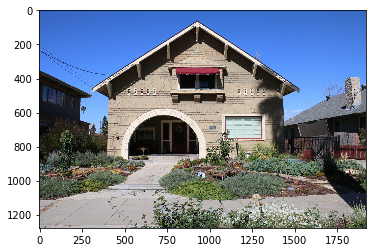

In [2]:
PATH = Path('../images')
HOUSE = 'house.png'
sz=288
content_img = open_image(PATH/HOUSE)
plt.imshow(content_img);

In [3]:
model = to_gpu(vgg16(True)).eval()

In [4]:
set_trainable(model, False)

In [5]:
trn_tfms, val_tfms = tfms_from_model(vgg16, sz)
content_tfmd_img = val_tfms(content_img)
content_tfmd_img.shape

(3, 288, 288)

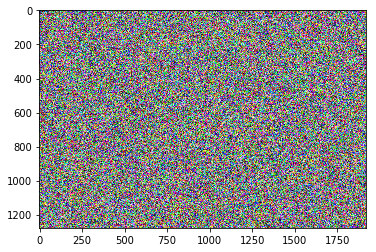

In [6]:
opt_img = np.random.uniform(0, 1, size=content_img.shape).astype(np.float32)
plt.imshow(opt_img);

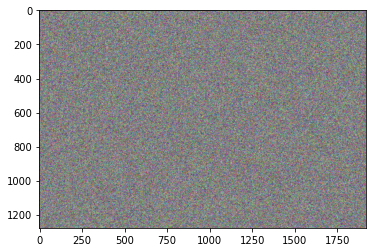

In [7]:
opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])
plt.imshow(opt_img);

In [8]:
opt_tfmd_img = val_tfms(opt_img)
opt_img_v = V(opt_tfmd_img[None], requires_grad=True)
opt_img_v.shape

torch.Size([1, 3, 288, 288])

In [9]:
model = nn.Sequential(*children(model)[:37])


We'll use VV, which creates a volatile Tensor: one which doesn't need gradients.

In [10]:
targ_t = model(VV(content_tfmd_img[None]))
targ_t.shape

torch.Size([1, 512, 18, 18])

In [11]:
max_iter = 1000
show_iter = 100
optimizer = optim.LBFGS([opt_img_v], lr=0.5)

In [12]:
def content_loss(x): return F.mse_loss(model(x), targ_t)*1000


In [13]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter+=1
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    return loss


In [14]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,content_loss))


Iteration: 100, loss: 0.8102316856384277
Iteration: 200, loss: 0.39843064546585083
Iteration: 300, loss: 0.2801513969898224
Iteration: 400, loss: 0.22585317492485046
Iteration: 500, loss: 0.19328820705413818
Iteration: 600, loss: 0.17246906459331512
Iteration: 700, loss: 0.15669964253902435
Iteration: 800, loss: 0.1452532410621643
Iteration: 900, loss: 0.13649778068065643
Iteration: 1000, loss: 0.1293805092573166


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


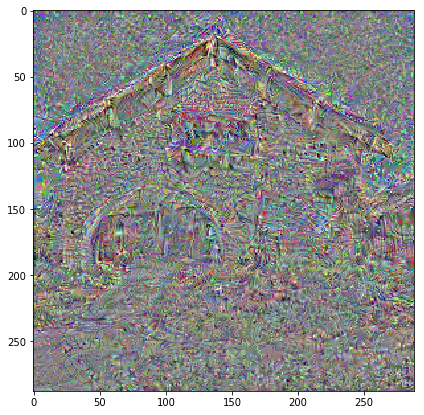

In [15]:
ht_width_depth = np.moveaxis(to_np(opt_img_v.data),1,-1)[0]
ht_width_depth.shape
x = val_tfms.denorm(ht_width_depth)
plt.figure(figsize=(7,7))
plt.imshow(x);


Try more levels

In [71]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

In [72]:
model = to_gpu(vgg16(True)).eval()
set_trainable(model, False)

In [73]:
block_ends = [i-1 for i,o in enumerate(children(model))
              if isinstance(o,nn.MaxPool2d)]
block_ends

[5, 12, 22, 32, 42]

In [74]:
sf = SaveFeatures(children(model)[block_ends[4]])

In [75]:
def get_opt():
    opt_img = np.random.uniform(0, 1, size=content_img.shape).astype(np.float32)
    opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])
    opt_img_v = V(val_tfms(opt_img/2)[None], requires_grad=True)
    return opt_img_v, optim.LBFGS([opt_img_v])

In [76]:
opt_img_v, optimizer = get_opt()

In [77]:
model(VV(content_tfmd_img[None]))
targ_v = V(sf.features.clone())
targ_v.shape

torch.Size([1, 512, 18, 18])

In [78]:
def actn_loss2(x):
    model(x)
    out = V(sf.features)
    return F.mse_loss(out, targ_v)*1000

In [ ]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss2))

Iteration: 100, loss: 2.8010237216949463
Iteration: 200, loss: 1.4073807001113892
Iteration: 300, loss: 0.9447845220565796
Iteration: 400, loss: 0.7195702791213989


In [ ]:
ht_width_depth = np.moveaxis(to_np(opt_img_v.data),1,-1)[0]
ht_width_depth.shape
x = val_tfms.denorm(ht_width_depth)
plt.figure(figsize=(7,7))
plt.imshow(x);

## Style


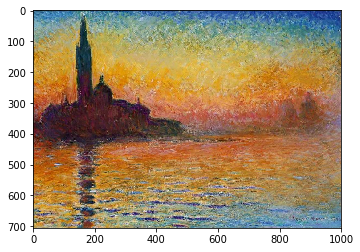

In [54]:
MONET = 'sunset-in-venice.jpg'
style_img = open_image(PATH/MONET)
plt.imshow(style_img);

In [55]:
def scale_match(src, targ):
    h,w,_ = src.shape
    sh,sw,_ = targ.shape
    rat = max(h/sh,w/sw); rat
    res = cv2.resize(targ, (int(sw*rat), int(sh*rat)))
    return res[:h,:w]

In [56]:
style = scale_match(content_img, style_img)


((1278, 1920, 3), (1278, 1920, 3))

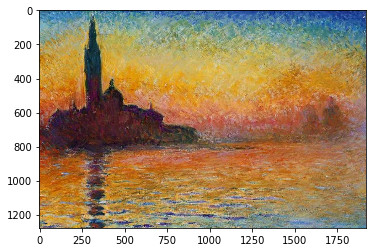

In [57]:
plt.imshow(style)
style.shape, content_img.shape


In [58]:
opt_img_v, optimizer = get_opt()

In [59]:
sfs = [SaveFeatures(children(model)[idx]) for idx in block_ends]

In [60]:
model(VV(content_tfmd_img[None]))
targ_vs = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_vs]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [61]:
style_tfmd_img = val_tfms(style_img)
model(VV(style_tfmd_img[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_vs]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [62]:
def gram(input):
        b,c,h,w = input.size()
        x = input.view(b*c, -1)
        return torch.mm(x, x.t())/input.numel()*1e6

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

In [63]:
def style_loss(x):
    model(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    return sum(losses)

In [64]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,style_loss))

Iteration: 100, loss: 175.93968200683594
Iteration: 200, loss: 22.950483322143555
Iteration: 300, loss: 7.77715539932251
Iteration: 400, loss: 3.9269914627075195
Iteration: 500, loss: 2.5299527645111084
Iteration: 600, loss: 1.8739185333251953
Iteration: 700, loss: 1.5214359760284424
Iteration: 800, loss: 1.3103986978530884
Iteration: 900, loss: 1.167064905166626
Iteration: 1000, loss: 1.060377836227417


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


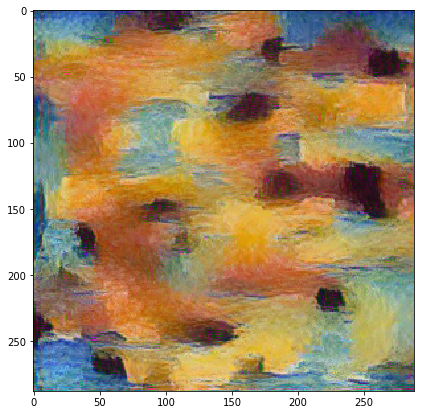

In [65]:
ht_width_depth = np.moveaxis(to_np(opt_img_v.data),1,-1)[0]
ht_width_depth.shape
x = val_tfms.denorm(ht_width_depth)
plt.figure(figsize=(7,7))
plt.imshow(x);

## Style Transfer

In [66]:
opt_img_v, optimizer = get_opt()

In [67]:
sfs = [SaveFeatures(children(model)[idx]) for idx in block_ends]

In [68]:
def comb_loss(x):
    model(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    cnt_loss   = F.mse_loss(outs[3], targ_vs[3])*1000000
    style_loss = sum(losses)
    return cnt_loss + style_loss

In [69]:
n_iter=0
max_iter=1000
while n_iter <= max_iter: optimizer.step(partial(step,comb_loss))

Iteration: 100, loss: 1455.38818359375
Iteration: 200, loss: 807.384521484375
Iteration: 300, loss: 573.6015625
Iteration: 400, loss: 474.98382568359375
Iteration: 500, loss: 430.16058349609375
Iteration: 600, loss: 403.7882080078125
Iteration: 700, loss: 385.804931640625
Iteration: 800, loss: 372.8528137207031
Iteration: 900, loss: 363.04180908203125
Iteration: 1000, loss: 355.1236267089844


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


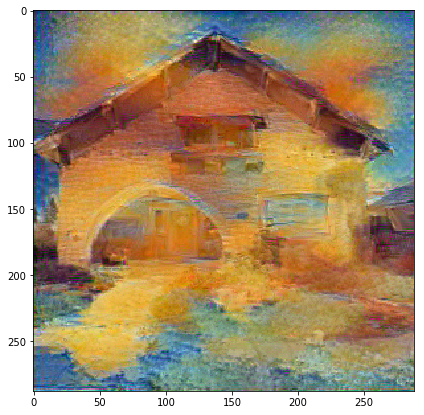

In [70]:
ht_width_depth = np.moveaxis(to_np(opt_img_v.data),1,-1)[0]
ht_width_depth.shape
x = val_tfms.denorm(ht_width_depth)
plt.figure(figsize=(7,7))
plt.imshow(x);